## Time Series feature Exploration
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.



In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

In [134]:
df = pd.read_csv(os.path.join('./data/raw', 'AirPassengers.csv'), parse_dates=["Month"])

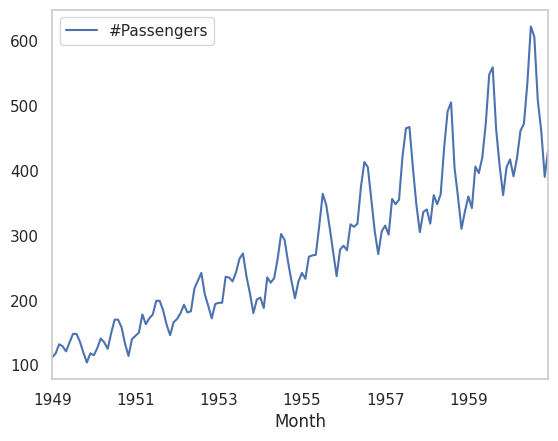

In [135]:
df.set_index("Month").plot()
plt.grid()
plt.show()

## 1.0 Seasonality and Trend removal

In [136]:
df = df.set_index("Month")
df2 = df.copy()

In [137]:
# In a monthly dataset the seasonality tends to be 12 periods - yearly seasonality
result = seasonal_decompose(df['#Passengers'], model='additive', period=12) # period = 7 for weekly seasonality
df['#Passengers_DETRENDED'] = df['#Passengers'] - result.trend
df['#Passengers_DESEASONALIZED'] = df['#Passengers'] - result.seasonal
df['#Passengers_Diff_1'] = df['#Passengers'].diff()
df['#Passengers_Diff_12'] = df['#Passengers'].diff(12)
df.head()

,#Passengers,#Passengers_DETRENDED,#Passengers_DESEASONALIZED,#Passengers_Diff_1,#Passengers_Diff_12
Month,,,,,
1949-01-01,112,NaN,136.748737,NaN,NaN
1949-02-01,118,NaN,154.188131,6.0,NaN
1949-03-01,132,NaN,134.241162,14.0,NaN
1949-04-01,129,NaN,137.036616,-3.0,NaN
1949-05-01,121,NaN,125.506313,-8.0,NaN


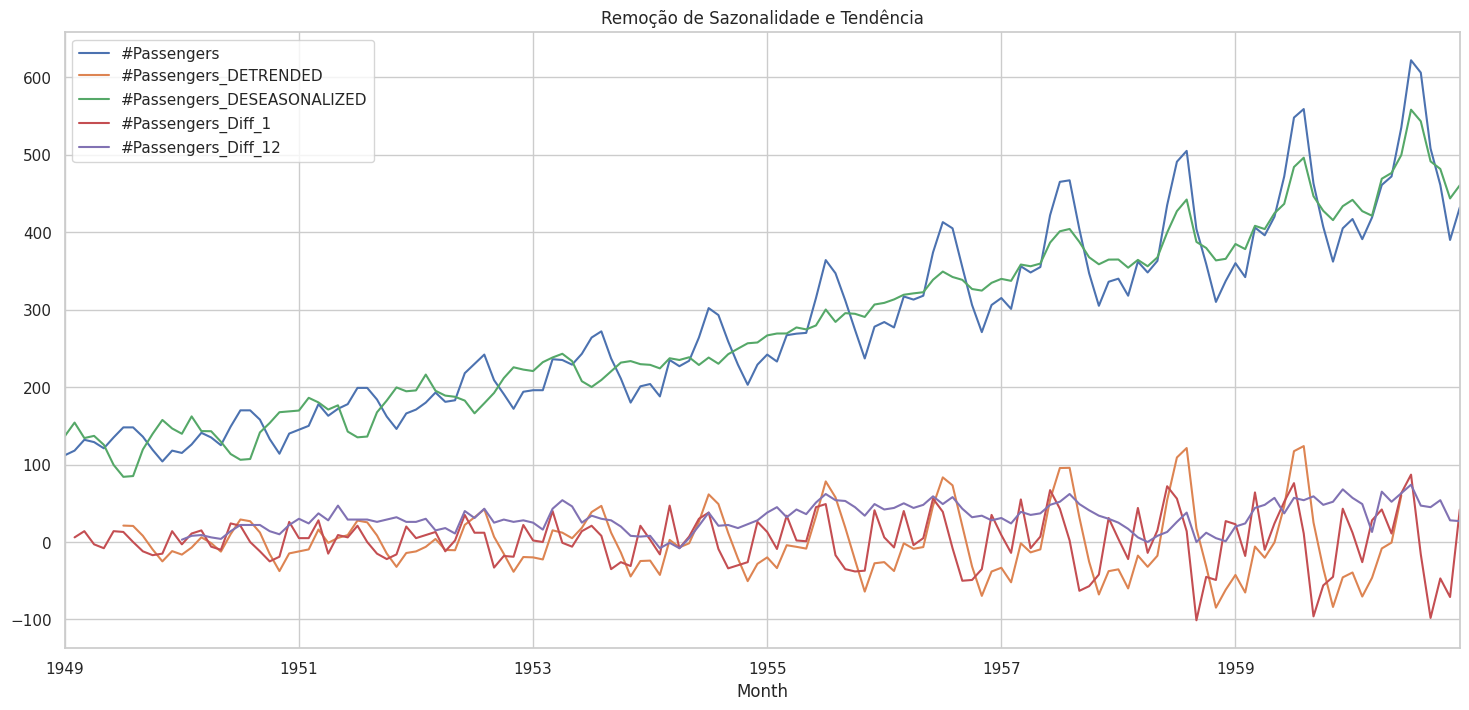

In [140]:
df.plot(figsize=(18, 8))
plt.title("Remoção de Sazonalidade e Tendência")
plt.show()

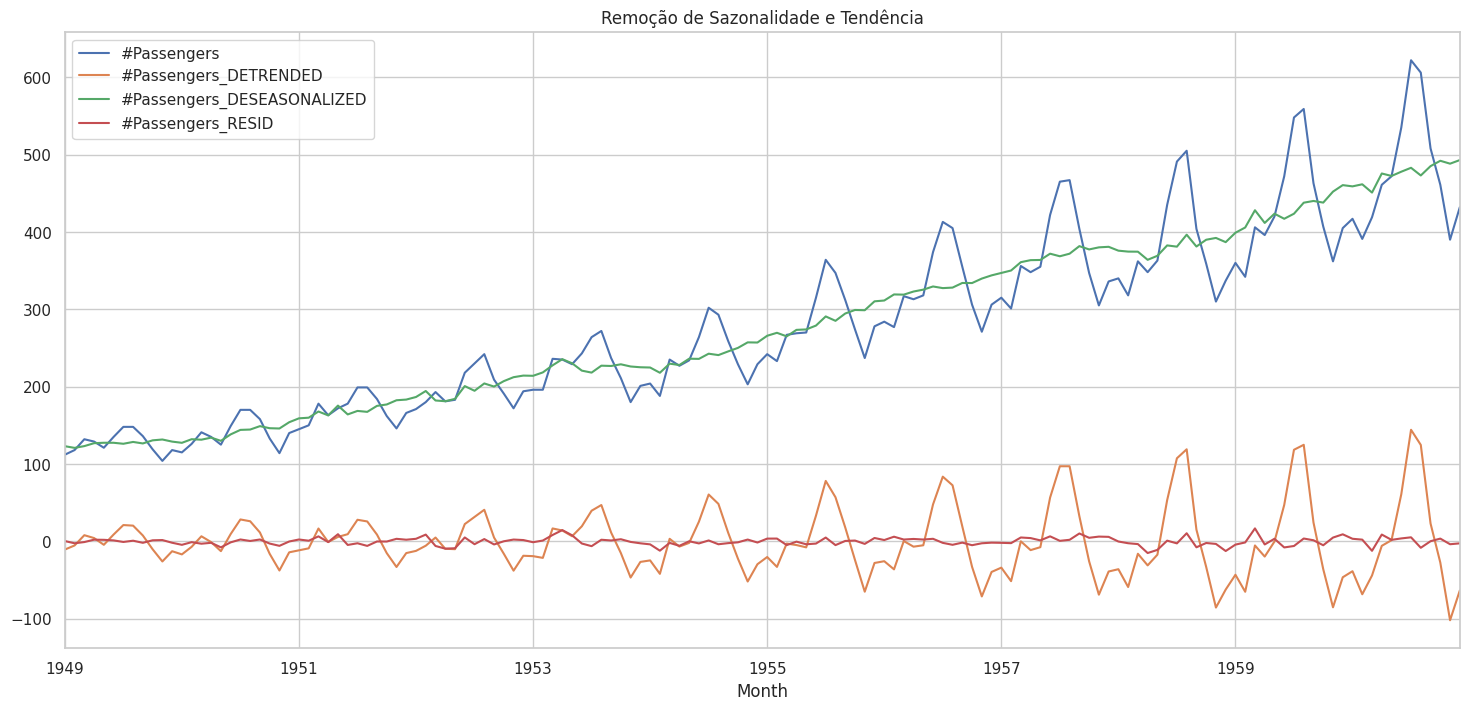

In [139]:
# STL decomposition
stl = STL(df['#Passengers'], period=12)
res = stl.fit()
df2['#Passengers_DETRENDED'] = df2['#Passengers'] - res.trend
df2['#Passengers_DESEASONALIZED'] = df2['#Passengers'] - res.seasonal
df2['#Passengers_RESID'] = df2['#Passengers_DETRENDED'] - res.seasonal

df2.plot(figsize=(18, 8), kind='line')
plt.title("Remoção de Sazonalidade e Tendência")
# plt.grid()
plt.show()

## 2.0 Training the models with and without the decomposition features

### 2.1 Without decomposition features

In [10]:
TARGET_NAME = "#Passengers"

df_without = df2[[TARGET_NAME]].copy()

FORECAST_HORIZON = 24

train_without = df_without.iloc[:-FORECAST_HORIZON]
test_without = df_without.iloc[-FORECAST_HORIZON:]

In [11]:
from src.features.feat_eng import *

In [12]:
train_without = train_without.reset_index()
train_without = train_without.rename(columns={"Month": "DATE"})
train_without = create_date_features(train_without)
train_without = train_without.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
X_train = train_without.drop(columns=[TARGET_NAME])
y_train = train_without[TARGET_NAME]
# train_without = train_without.set_index("Month")

test_without = test_without.reset_index()
test_without = test_without.rename(columns={"Month": "DATE"})
test_without = create_date_features(test_without)
test_without = test_without.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
X_test = test_without.drop(columns=[TARGET_NAME])
y_test = test_without[TARGET_NAME]
# test_without = test_without.set_index("Month")

In [13]:
model = train_model(X_train.drop(columns=["DATE"]), y_train, 'ET', 'Seasonal', load_best_params=False)

In [14]:
predictions = model.predict(X_test.drop(columns=["DATE"]))
train_predictions = model.predict(X_train.drop(columns=["DATE"]))

In [15]:
def calculate_metrics(pred_df, actuals, predictions):
    logger.debug("Calculating the evaluation metrics...")
    
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
    model_mae = round(mean_absolute_error(actuals, predictions), 2)
    model_wape = round((pred_df.ACTUAL - pred_df.FORECAST).abs().sum() / pred_df.ACTUAL.sum(), 2)

    pred_df["MAPE"] = model_mape
    pred_df["MAE"] = model_mae
    pred_df["WAPE"] = model_wape
    pred_df["RMSE"] = model_rmse

    return pred_df

In [16]:
pred_df = test_without.copy()
train_pred_df = train_without.copy()

In [17]:
pred_df = pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
pred_df["FORECAST"] = predictions

train_pred_df = train_pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
train_pred_df["FORECAST"] = train_predictions

In [18]:
pred_df = calculate_metrics(pred_df, test_without[TARGET_NAME], predictions)
train_pred_df = calculate_metrics(train_pred_df, train_without[TARGET_NAME], train_predictions)

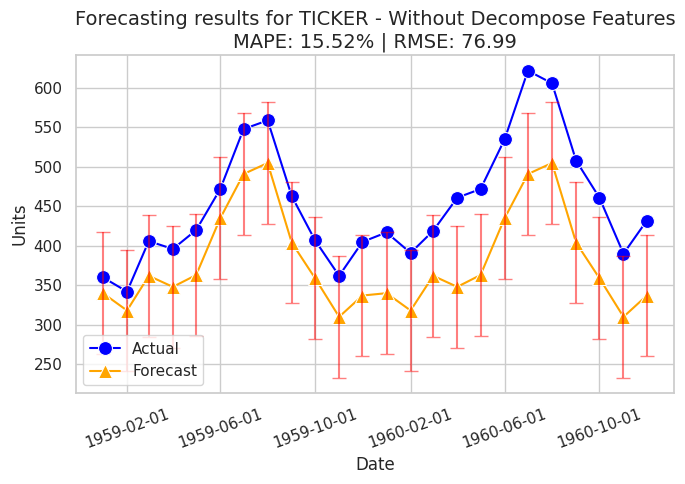

In [19]:
visualize_validation_results(pred_df, "Without Decompose Features")

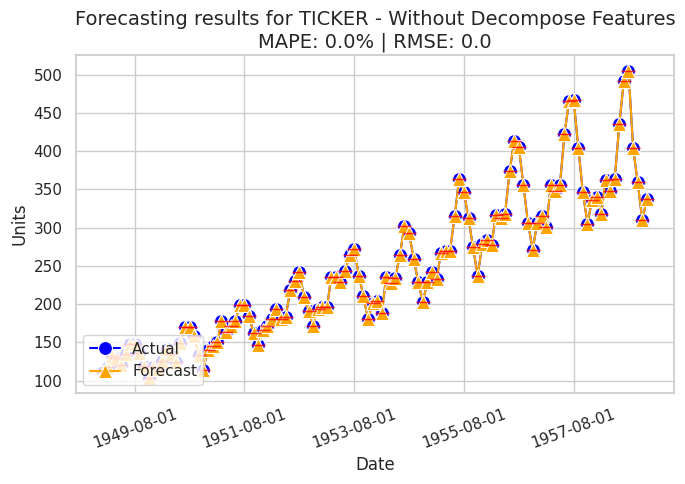

In [20]:
visualize_validation_results(train_pred_df, "Without Decompose Features")

### 2.2 With Decompose features

In [101]:
TARGET_NAME = "#Passengers"

df_with = df2.copy()


FORECAST_HORIZON = 24

train_with = df_with.iloc[:-FORECAST_HORIZON]
test_with = df_with.iloc[-FORECAST_HORIZON:]

In [102]:
train_with = train_with.reset_index()
train_with = train_with.rename(columns={"Month": "DATE"})
train_with = create_date_features(train_with)
train_with = train_with.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
train_with["Volatility"] = train_with[TARGET_NAME].rolling(window=3, closed='left', min_periods=1).std()
train_with.dropna(inplace=True)
X_train = train_with.drop(columns=[TARGET_NAME])
y_train = train_with[TARGET_NAME]
# train_with = train_with.set_index("Month")

test_with = test_with.reset_index()
test_with = test_with.rename(columns={"Month": "DATE"})
test_with = create_date_features(test_with)
test_with = test_with.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
X_test = test_with.drop(columns=[TARGET_NAME])
y_test = test_with[TARGET_NAME]
# test_with = test_with.set_index("Month")

In [103]:
X_test["Volatility"] = X_train["Volatility"][-24:].values

In [104]:
X_test["Volatility"] = 1.2*X_test["Volatility"] 

In [105]:
X_train.head()

,DATE,#Passengers_DETRENDED,#Passengers_DESEASONALIZED,#Passengers_RESID,MONTH,QUARTER,YEAR,Volatility
2,1949-03-01,7.943882,123.121683,-0.934435,3,1,1949,4.242641
3,1949-04-01,4.231064,126.912789,2.143853,4,2,1949,10.263203
4,1949-05-01,-4.487065,127.443116,1.956051,5,2,1949,7.371115
5,1949-06-01,8.786406,127.432360,1.218765,6,2,1949,5.686241
6,1949-07-01,21.049230,126.149038,-0.801732,7,3,1949,7.023769


In [122]:
model = train_model(X_train.drop(columns=["DATE"]), y_train, 'ADA', 'Seasonal', load_best_params=False)

In [123]:
predictions = model.predict(X_test.drop(columns=["DATE"]))
train_predictions = model.predict(X_train.drop(columns=["DATE"]))

In [124]:
pred_df = test_with.copy()
train_pred_df = train_with.copy()

In [125]:
pred_df = pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
pred_df["FORECAST"] = predictions

train_pred_df = train_pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
train_pred_df["FORECAST"] = train_predictions

In [126]:
pred_df = calculate_metrics(pred_df, test_with[TARGET_NAME], predictions)
train_pred_df = calculate_metrics(train_pred_df, train_with[TARGET_NAME], train_predictions)

In [127]:
pred_df.head()

,DATE,ACTUAL,#Passengers_DETRENDED,#Passengers_DESEASONALIZED,#Passengers_RESID,MONTH,QUARTER,YEAR,FORECAST,MAPE,MAE,WAPE,RMSE
0,1959-01-01,360,-43.224916,398.990807,-4.234108,1,1,1959,337.024390,0.1774,82.42,0.18,89.24
1,1959-02-01,342,-65.204180,405.770200,-1.433981,2,1,1959,333.722222,0.1774,82.42,0.18,89.24
2,1959-03-01,406,-5.340612,428.065815,16.725203,3,1,1959,345.142857,0.1774,82.42,0.18,89.24
3,1959-04-01,396,-19.703257,411.676171,-4.027086,4,2,1959,345.142857,0.1774,82.42,0.18,89.24
4,1959-05-01,420,-0.276640,423.587663,3.311023,5,2,1959,346.588235,0.1774,82.42,0.18,89.24


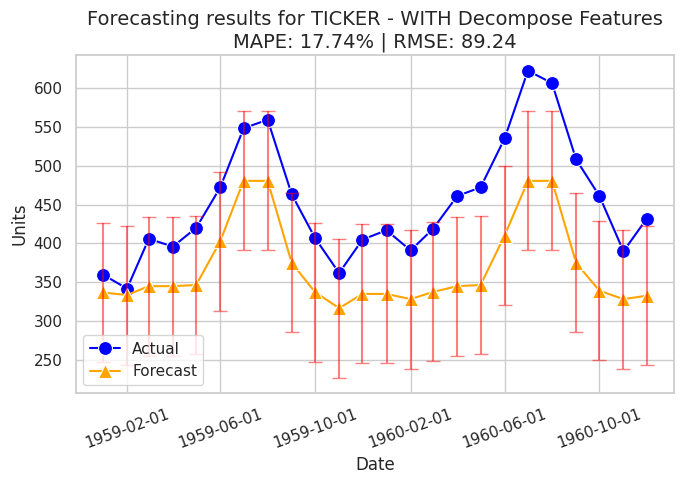

In [128]:
visualize_validation_results(pred_df, "WITH Decompose Features")

In [1]:
visualize_validation_results(train_pred_df, "WITH Decompose Features")

NameError: name 'visualize_validation_results' is not defined